In [1]:
! pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax.numpy as jnp
import jax
from jax import random
import numpy as np

from flax import linen as nn
from flax.training import train_state

import optax

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
latents = 128
num_epochs = 50
batch_size = 128
learning_rate = 1e-3

In [5]:
# class Encoder(nn.Module):
#     latents: int

#     @nn.compact
#     def __call__(self, x):
#         x = nn.Dense(500, name='fc1')(x)
#         x = nn.relu(x)
#         mean_x = nn.Dense(self.latents, name='fc2_mean')(x)
#         logvar_x = nn.Dense(self.latents, name='fc2_logvar')(x)
#         return mean_x, logvar_x

class Decoder(nn.Module):

    @nn.compact
    def __call__(self, z):
        z = nn.Dense(500, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(784, name='fc2')(z)
        return z

class Encoder(nn.Module):
    c_hid : int = 32
    latents : int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x) 
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.c_hid, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
        mean_x = nn.Dense(self.latents)(x)
        logvar_x = nn.Dense(self.latents)(x)
        return mean_x, logvar_x

class Decoder(nn.Module):
    c_out : int = 1
    c_hid : int = 32

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=7 * 7 *self.c_hid)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], 7, 7, -1)
        x = nn.ConvTranspose(features=2 * self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3, 3), strides=(1, 1))(x)
        return x

class VAE(nn.Module):
    latents: int = 20

    def setup(self):
        self.encoder = Encoder(latents=self.latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def generate(self, z):
        return nn.sigmoid(self.decoder(z))


def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))


def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

def model():
    return VAE(latents=latents)


In [6]:
@jax.jit
def train_step(state, batch, z_rng):
  def loss_fn(params):
    recon_x, mean, logvar = model().apply({'params': params}, batch, z_rng)

    bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = bce_loss + kld_loss
    return loss
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


# @jax.jit
# def eval(params, images, z, z_rng):
#   def eval_model(vae):
#     recon_images, mean, logvar = vae(images, z_rng)
#     comparison = jnp.concatenate([images[:8].reshape(-1, 28, 28, 1),
#                                   recon_images[:8].reshape(-1, 28, 28, 1)])

#     generate_images = vae.generate(z)
#     generate_images = generate_images.reshape(-1, 28, 28, 1)
#     metrics = compute_metrics(recon_images, images, mean, logvar)
#     return metrics, comparison, generate_images

#   return nn.apply(eval_model, model())({'params': params})


@jax.jit
def eval(params, images, z, z_rng):
  def eval_model(vae):
    recon_images, mean, logvar = vae(images, z_rng)
    comparison = jnp.concatenate([images[:8].reshape(-1, 28, 28, 1),
                                  recon_images[:8].reshape(-1, 28, 28, 1)])

    generate_images = vae.generate(z)
    generate_images = generate_images.reshape(-1, 28, 28, 1)
    metrics = compute_metrics(recon_images, images, mean, logvar)
    return metrics, comparison, generate_images

  return nn.apply(eval_model, model())({'params': params})

def prepare_image(x):
  x = tf.cast(x['image'], tf.float32)
  # x = tf.reshape(x, (-1,))
  return x

In [7]:
# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], 'GPU')

rng = random.PRNGKey(0)
rng, key = random.split(rng)

ds_builder = tfds.builder('binarized_mnist')
ds_builder.download_and_prepare()
train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.cache()
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.batch(batch_size)
train_ds = iter(tfds.as_numpy(train_ds))

test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
test_ds = test_ds.map(prepare_image).batch(10000)
test_ds = np.array(list(test_ds)[0])
test_ds = jax.device_put(test_ds)


In [8]:
init_data = jnp.ones((batch_size, 28, 28, 1), jnp.float32)

state = train_state.TrainState.create(
    apply_fn=model().apply,
    params=model().init(key, init_data, rng)['params'],
    tx=optax.adam(learning_rate),
)

rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (64, latents))

steps_per_epoch = 50000 // batch_size

for epoch in range(num_epochs):
  for _ in range(steps_per_epoch):
    batch = next(train_ds)
    rng, key = random.split(rng)
    state = train_step(state, batch, key)

  metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

  print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
      epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
  ))

eval epoch: 2, loss: 119.8892, BCE: 86.7981, KLD: 33.0911
eval epoch: 3, loss: 112.1238, BCE: 80.4740, KLD: 31.6499
eval epoch: 4, loss: 107.9409, BCE: 76.4232, KLD: 31.5177
eval epoch: 5, loss: 105.1747, BCE: 73.3762, KLD: 31.7985
eval epoch: 6, loss: 103.6083, BCE: 72.7858, KLD: 30.8225
eval epoch: 7, loss: 102.5286, BCE: 72.1471, KLD: 30.3815
eval epoch: 8, loss: 101.3283, BCE: 70.4642, KLD: 30.8641
eval epoch: 9, loss: 100.7159, BCE: 69.9050, KLD: 30.8109
eval epoch: 10, loss: 100.3642, BCE: 68.6687, KLD: 31.6955
eval epoch: 11, loss: 99.6911, BCE: 68.3035, KLD: 31.3876
eval epoch: 12, loss: 99.1876, BCE: 67.0684, KLD: 32.1191
eval epoch: 13, loss: 98.8886, BCE: 67.7235, KLD: 31.1650
eval epoch: 14, loss: 98.6167, BCE: 67.8765, KLD: 30.7402
eval epoch: 15, loss: 98.3571, BCE: 67.0892, KLD: 31.2679
eval epoch: 16, loss: 98.1799, BCE: 67.5425, KLD: 30.6374
eval epoch: 17, loss: 97.8683, BCE: 67.0859, KLD: 30.7824
eval epoch: 18, loss: 97.7834, BCE: 65.5452, KLD: 32.2382
eval epoch: 1

In [9]:
rng = jax.random.PRNGKey(1)
rng, z_key, eval_rng = random.split(rng, 3)
z = jax.random.normal(z_key, (16, latents))

In [10]:
metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

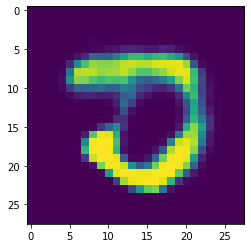

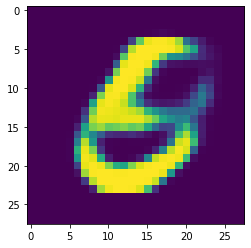

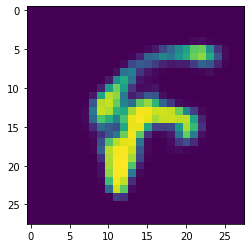

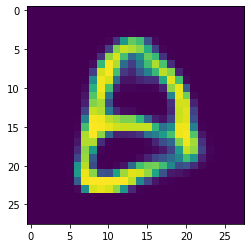

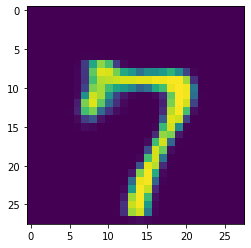

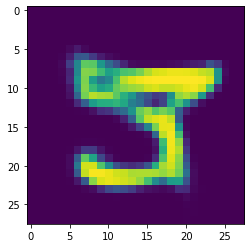

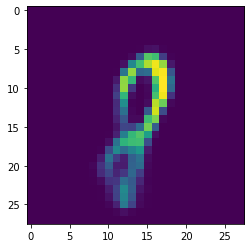

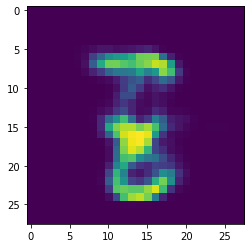

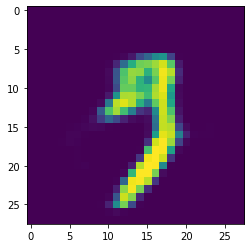

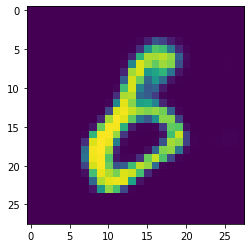

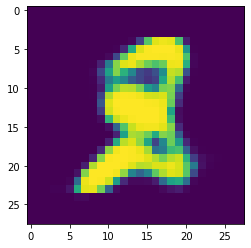

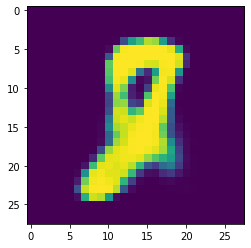

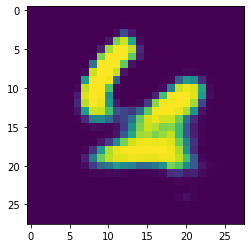

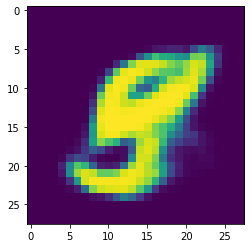

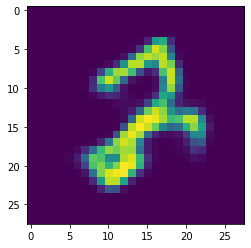

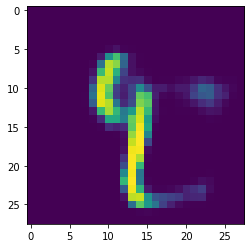

In [11]:
import matplotlib.pyplot as plt

for i in range(16):
  plt.imshow(sample[i, :, :, 0])
  plt.show()

In [ ]:
)